In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import ast
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

%load_ext lab_black

In [2]:
# DIR_INPUT = '/kaggle/input/global-wheat-detection'
TRAIN_DIR = f"../data/wheat/train"
TEST_DIR = f"../data/wheat/test/"
WEIGHTS_FILE = f"./fasterrcnn_resnet50_fpn.pth"
test_df = pd.read_csv("../data/wheat/sample_submission.csv")

In [3]:
def PIL_read(path: str) -> np.ndarray:
    img = Image.open(path)
    img = np.asarray(img)
    return img

In [4]:
class WheatTestDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None) -> None:
        super().__init__()
        self.image_ids = dataframe["image_id"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        # get all records of that image_id
        records = self.df[self.df["image_id"] == image_id]
        image = PIL_read(f"{self.image_dir}/{image_id}.jpg").astype(np.float32)
        # image = cv2.imread(f"{self.image_dir}/{image_id}.jpg", cv2.IMREAD_COLOR)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {"image": image}
            sample = self.transforms(**sample)
            image = sample["image"]

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [5]:
# Albumentations
def get_test_transform():
    return A.Compose(
        [
            # A.Resize(512, 512),
            ToTensorV2(p=1.0)
        ]
    )

In [6]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=False, pretrained_backbone=False
)

d:\Python\General\03_Projects\neural_nets\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python\General\03_Projects\neural_nets\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
d:\Python\General\03_Projects\neural_nets\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
d:\Python\General\03_Projects\neural_nets\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone

In [7]:
# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))
model.eval()

x = model.to(device)

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))


test_dataset = WheatTestDataset(test_df, TEST_DIR, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    drop_last=False,
    collate_fn=collate_fn,
)

In [10]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append(
            "{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3])
        )

    return " ".join(pred_strings)

In [11]:
detection_threshold = 0.5
results = []

for images, image_ids in test_data_loader:
    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):
        boxes = outputs[i]["boxes"].data.cpu().numpy()
        scores = outputs[i]["scores"].data.cpu().numpy()

        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            "image_id": image_id,
            "PredictionString": format_prediction_string(boxes, scores),
        }

        results.append(result)

In [12]:
results[0:2]

[{'image_id': 'aac893a91',
  'PredictionString': '0.9888 72 0 99 158 0.9795 616 915 78 108 0.9713 590 778 91 120 0.9710 557 526 121 196 0.9700 359 527 95 86 0.9657 740 769 77 117 0.9637 30 450 96 146 0.9619 820 706 104 200 0.9594 695 388 115 175 0.9582 552 58 136 196 0.9523 331 661 119 152 0.9501 460 855 80 92 0.9458 181 568 112 182 0.9284 233 845 142 82 0.9271 62 853 120 71 0.9123 90 617 123 72 0.9063 307 0 71 64 0.8910 274 120 102 107 0.7538 334 905 66 57 0.6070 818 937 128 84 0.5681 165 2 79 141 0.5251 637 1 101 111'},
 {'image_id': '51f1be19e',
  'PredictionString': '0.9781 611 77 160 183 0.9632 498 468 212 106 0.9417 770 885 148 97 0.9369 811 88 118 74 0.9301 810 760 103 94 0.9281 649 790 117 79 0.9231 287 476 123 112 0.9194 0 379 56 101 0.9193 71 695 124 211 0.9035 27 0 88 68 0.8854 857 269 116 195 0.8789 192 930 103 91 0.8782 695 915 86 89 0.8634 354 135 88 181 0.8306 249 120 81 118 0.8194 854 648 162 99 0.7991 565 583 126 133 0.7670 777 25 112 66 0.6591 681 605 85 74 0.5600 516

In [13]:
test_df = pd.DataFrame(results, columns=["image_id", "PredictionString"])
test_df.head()

,image_id,PredictionString
0,aac893a91,0.9888 72 0 99 158 0.9795 616 915 78 108 0.971...
1,51f1be19e,0.9781 611 77 160 183 0.9632 498 468 212 106 0...
2,f5a1f0358,0.9822 887 642 89 143 0.9741 542 270 112 111 0...
3,796707dd7,0.9742 30 79 180 137 0.9720 938 67 85 107 0.97...
4,51b3e36ab,0.9908 541 28 252 132 0.9904 869 284 155 142 0...


In [14]:
sample = images[1].permute(1, 2, 0).cpu().numpy()
boxes = outputs[1]["boxes"].data.cpu().numpy()
scores = outputs[1]["scores"].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


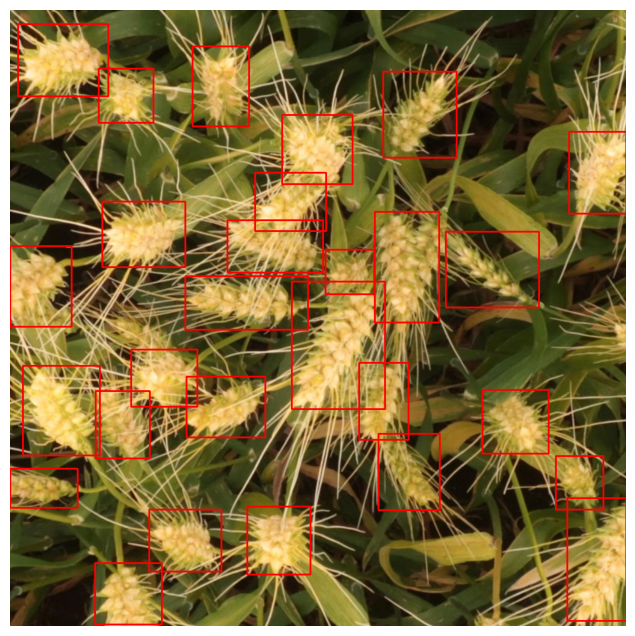

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (220, 0, 0), 2)

ax.set_axis_off()
ax.imshow(sample)